# 0. Libraries 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Part 1: Data Cleaning and Preprocessing

## 1.1 Load and Inspect the Dataset
__1.1.1__ Load the dataset and display its shape, column names, and data types.

__1.1.2__  Identify and list the number of missing values in each column.

__1.1.3__  Eliminate unnecessary columns. 

In [7]:
# 1.1.1 Load the dataset and display its shape, column names, and data
df = pd.read_csv("customer_segmentation_data.csv")
print('Number of Rows and Columns :', df.shape, '\n')   #shape
print('Column names:', df.columns, '\n')                #Columns names
print(df.info(), '\n')
df.head()   


Number of Rows and Columns : (1000, 9) 

Column names: Index(['id', 'age', 'gender', 'income', 'spending_score', 'membership_years',
       'purchase_frequency', 'preferred_category', 'last_purchase_amount'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   age                   1000 non-null   int64  
 2   gender                1000 non-null   object 
 3   income                1000 non-null   int64  
 4   spending_score        1000 non-null   int64  
 5   membership_years      1000 non-null   int64  
 6   purchase_frequency    1000 non-null   int64  
 7   preferred_category    1000 non-null   object 
 8   last_purchase_amount  1000 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 70.4+ KB
None 



,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


In [8]:
# 1.1.2 Identify and list the number of missing values in each column.
number_missing_values = df.isnull().sum()    #Missing data for each column
number_missing_values

id                      0
age                     0
gender                  0
income                  0
spending_score          0
membership_years        0
purchase_frequency      0
preferred_category      0
last_purchase_amount    0
dtype: int64

In [9]:
# 1.1.3 Eliminate unnecessary columns
df = df.drop(['id'], axis=1)
df.head()

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,38,Female,99342,90,3,24,Groceries,113.53
1,21,Female,78852,60,2,42,Sports,41.93
2,60,Female,126573,30,2,28,Clothing,424.36
3,40,Other,47099,74,9,5,Home & Garden,991.93
4,65,Female,140621,21,3,25,Electronics,347.08


## 1.2 Outliers
__1.2.1__ Identify outliers in each numerical column using IQR method


__1.2.2__ Replace detected outliers with the nearest quartile value to minimize distortion in the data distribution. 


In [11]:
# 1.2.1 Identify outliers in each numerical column using IQR method
def identify_outliers(df):
    outliers = {}
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers[col] = outliers.index.tolist()
        
        print(f"Column: {col}")
        print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f"Number of outliers: {len(outliers)}")
        print("_"*50)
    
    return outliers

identify_outliers(df)

Column: age
Q1: 30.00, Q3: 57.00, IQR: 27.00
Lower bound: -10.50, Upper bound: 97.50
Number of outliers: 0
__________________________________________________
Column: income
Q1: 57911.75, Q3: 116110.25, IQR: 58198.50
Lower bound: -29386.00, Upper bound: 203408.00
Number of outliers: 0
__________________________________________________
Column: spending_score
Q1: 26.00, Q3: 76.00, IQR: 50.00
Lower bound: -49.00, Upper bound: 151.00
Number of outliers: 0
__________________________________________________
Column: membership_years
Q1: 3.00, Q3: 8.00, IQR: 5.00
Lower bound: -4.50, Upper bound: 15.50
Number of outliers: 0
__________________________________________________
Column: purchase_frequency
Q1: 15.00, Q3: 39.00, IQR: 24.00
Lower bound: -21.00, Upper bound: 75.00
Number of outliers: 0
__________________________________________________
Column: last_purchase_amount
Q1: 218.76, Q3: 747.17, IQR: 528.41
Lower bound: -573.85, Upper bound: 1539.78
Number of outliers: 0
________________________

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount


## 1.3 CATEGORICAL GROUPING

__1.3.1__ Examine the number of unique categories present in the 'preferred_category' column to assess the diversity of customer preferences.

__1.3.2__ Evaluate the feasibility of grouping categories if the cardinality is high. This step helps reduce dimensionality and improve model performance by consolidating similar or low-frequency categories into broader groups. 

In [13]:
# 1.3.1 Examine the number of unique categories present in the preferred_category column to assess the diversity of customer preferences.
# 1.3.2 Evaluate the feasibility of grouping categories if the cardinality is high.

counts = df['preferred_category'].value_counts()
percentages = counts / counts.sum() * 100

category_df = pd.DataFrame({
    'Category': counts.index,
    'Count': counts.values,
    'Percentage': percentages.values
})

category_df 

,Category,Count,Percentage
0,Electronics,215,21.5
1,Sports,210,21.0
2,Home & Garden,206,20.6
3,Groceries,199,19.9
4,Clothing,170,17.0


# Part 2: Exploratory Data Analysis (EDA)

Obj: Identify behavioral patterns based on customer membership duration.

__2.1__ What trends in purchase frequency are associated with the number of membership years?

In [15]:
# 2.1 What trends in purchase frequency are associated with the number of membership years?
behavioral_loyalty = df.groupby('membership_years').agg(
    avg_purchase=('purchase_frequency', 'mean'),
).reset_index()

behavioral_loyalty

,membership_years,avg_purchase
0,1,25.600000
1,2,25.944954
2,3,25.073684
3,4,26.414894
4,5,26.056000
5,6,26.760417
6,7,25.414894
7,8,27.306818
8,9,28.361111
9,10,29.062500


Text(0.5, 1.0, 'Trend of Purchase Frequency by Membership Duration')

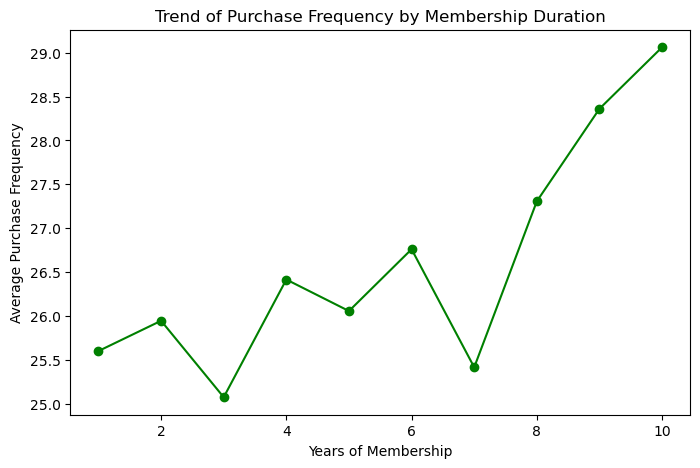

In [16]:
behavioral_loyalty = df.groupby('membership_years').agg(
    avg_purchase=('purchase_frequency', 'mean'),
).reset_index()

#Plot
plt.figure(figsize=(8, 5))
plt.plot(behavioral_loyalty['membership_years'], behavioral_loyalty['avg_purchase'], marker='o', linestyle='-', color='green')

plt.xlabel("Years of Membership")
plt.ylabel("Average Purchase Frequency")
plt.title("Trend of Purchase Frequency by Membership Duration")
# plt.ylim(bottom=0) 

# Part 3: Statistical Data Objectives and Questions

Obj: Assess the relationship between preferred shopping category and spending score.

__3.1__ Is there a significant relationship between a customer's preferred category and their spending score?

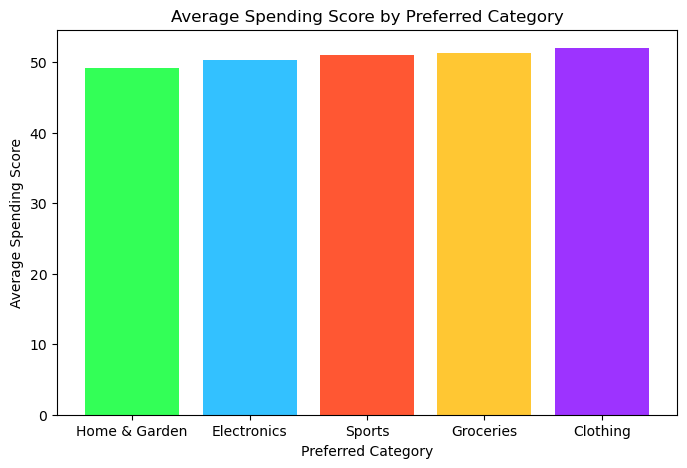

In [18]:
score_category = df.groupby('preferred_category').agg(
    avg_score=('spending_score', 'mean'),
).reset_index()
score_category = score_category.sort_values('avg_score').reset_index(drop=True)

plt.figure(figsize=(8, 5))
colors = ['#33FF57', '#33C1FF' , '#FF5733' , '#FFC733', '#9D33FF']
bars = plt.bar(score_category['preferred_category'], score_category['avg_score'], color=colors)


plt.xlabel("Preferred Category")
plt.ylabel("Average Spending Score")
plt.title("Average Spending Score by Preferred Category")

plt.show()


In [19]:
score_category

,preferred_category,avg_score
0,Home & Garden,49.135922
1,Electronics,50.297674
2,Sports,51.014286
3,Groceries,51.256281
4,Clothing,51.976471


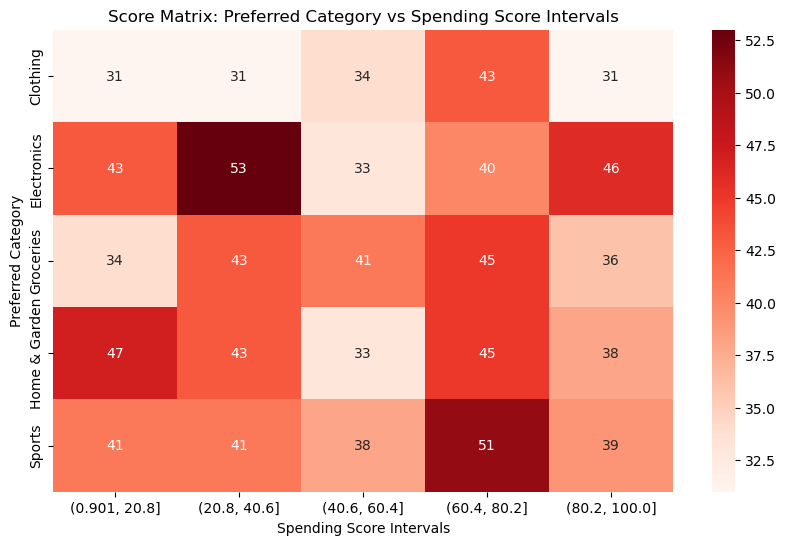

In [20]:
df['spending_bin'] = pd.cut(df['spending_score'], bins=5)
score_matrix = pd.crosstab(df['preferred_category'], df['spending_bin'])

plt.figure(figsize=(10, 6))
sns.heatmap(score_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Score Matrix: Preferred Category vs Spending Score Intervals')
plt.xlabel('Spending Score Intervals')
plt.ylabel('Preferred Category')
plt.show()

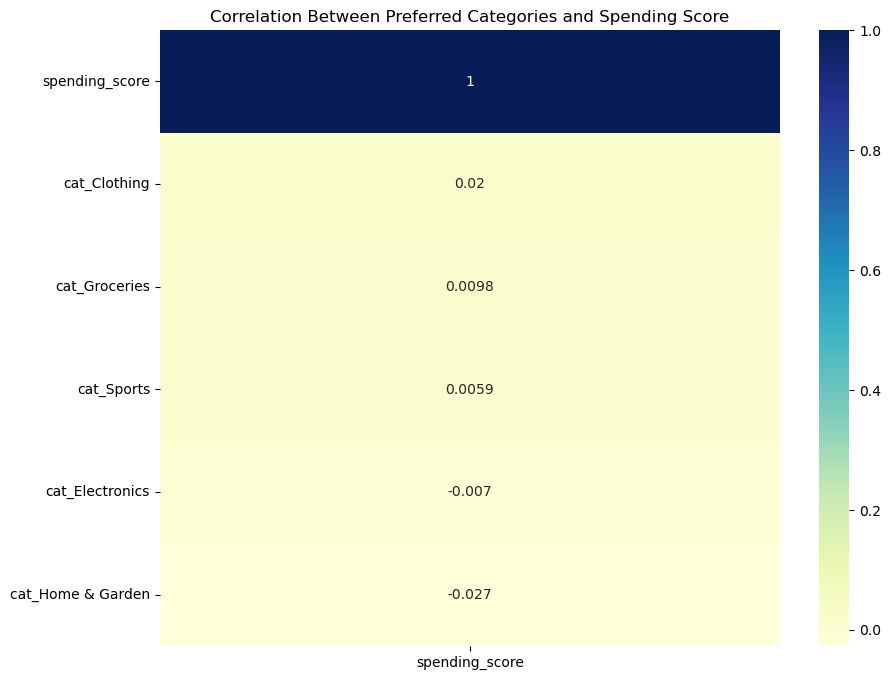

In [21]:
# One-hot encoding
encoded_df = pd.get_dummies(df[['preferred_category']], prefix='cat')
encoded_df['spending_score'] = df['spending_score']

corr_matrix = encoded_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['spending_score']].sort_values(by='spending_score', ascending=False), annot=True, cmap='YlGnBu')
plt.title('Correlation Between Preferred Categories and Spending Score')
plt.show()


# Part 4. Machine Learning 

## 4.1 Creacion de la variable Lealtad 
esta se dio apartir de lo que se encontro en los resultados donde la tendencia despues de 3 anos de membresia y un mayor promedio en frecuency buy se puede establecer si el cliente es leal o no. 

In [24]:
avg_freq = df['purchase_frequency'].mean()

df['loyalty'] = np.where(
    (df['membership_years'] > 3) & (df['purchase_frequency'] > avg_freq),
    'yes',
    'no'
)

In [25]:
df.head()

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount,spending_bin,loyalty
0,38,Female,99342,90,3,24,Groceries,113.53,"(80.2, 100.0]",no
1,21,Female,78852,60,2,42,Sports,41.93,"(40.6, 60.4]",no
2,60,Female,126573,30,2,28,Clothing,424.36,"(20.8, 40.6]",no
3,40,Other,47099,74,9,5,Home & Garden,991.93,"(60.4, 80.2]",no
4,65,Female,140621,21,3,25,Electronics,347.08,"(20.8, 40.6]",no


In [26]:
score_category = df.groupby('loyalty').agg(
    count_customers=('loyalty', 'count'),
).reset_index()


score_category

,loyalty,count_customers
0,no,627
1,yes,373


In [27]:
#Eliminacion de las dos columnas usadas para definir loyalty
df = df.drop(columns=['membership_years', 'purchase_frequency', 'spending_bin'])
df.head()

,age,gender,income,spending_score,preferred_category,last_purchase_amount,loyalty
0,38,Female,99342,90,Groceries,113.53,no
1,21,Female,78852,60,Sports,41.93,no
2,60,Female,126573,30,Clothing,424.36,no
3,40,Other,47099,74,Home & Garden,991.93,no
4,65,Female,140621,21,Electronics,347.08,no


In [28]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['gender', 'preferred_category', 'loyalty'], dtype='object')

label_encoder = LabelEncoder()

# List of categorical columns to encode
# Added 'school' to the list as it's a categorical column not previously included
categorical_columns = 

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'G3' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'] == 'Yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'loyalty' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Display the first 3 rows of the standardized training data
print("First 3 rows of standardized training data:")
X_train_scaled_df.head(3)

First 3 rows of standardized training data:


,age,gender,income,spending_score,preferred_category,last_purchase_amount
0,1.665154,1.230544,-0.055969,0.635544,-1.486120,1.076039
1,0.147951,-0.026946,-0.578556,-0.052647,-1.486120,-0.359977
2,0.016020,-1.284437,-1.335153,0.119401,-0.031177,0.012758


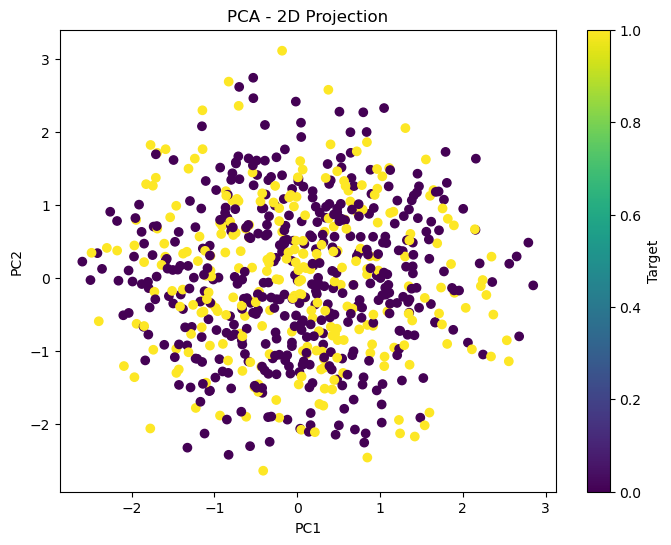

In [31]:
# Dimensionality Reduction - PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)
X_pca

# Plot PCA results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.title("PCA - 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Target')
plt.show()

In [32]:
print(df['loyalty'].value_counts())

loyalty
no     627
yes    373
Name: count, dtype: int64


In [33]:
variance = pca.explained_variance_ratio_
variance_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(variance))],
    'Variance Ratio': variance
})
variance_df

,Component,Variance Ratio
0,PC1,0.192430
1,PC2,0.179341
2,PC3,0.166455


In [97]:
lol = df.groupby('cluster').agg({
    'age': 'mean',
    'income': 'mean',
    'spending_score': 'mean'
})

lol 

,age,income,spending_score
cluster,,,
0,47.547170,79817.452830,36.814465
1,40.359621,96223.634069,29.504732
2,43.476712,89358.789041,81.164384


In [75]:
# Convert the PCA results to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Display the first 5 rows
print("First 5 rows of PCA results:")
X_pca_df.head()

ValueError: Shape of passed values is (1000, 2), indices imply (1000, 3)

In [ ]:
# Dimensionality Reduction - t-SNE
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X_train_scaled)

# Plot t-SNE results
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.title("t-SNE - 2D Projection")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='Target')
plt.show()

In [ ]:
#LDA (Linear Discriminant Analysis) chart

# Dimensionality Reduction - LDA
lda = LDA(n_components=1) # For binary classification, LDA reduces to n_classes - 1 dimension
X_lda = lda.fit_transform(X_train_scaled, y_train)

# Plot LDA results
plt.figure(figsize=(8,6))
# LDA for binary classification reduces to a single dimension, so we can plot a histogram
plt.hist(X_lda[y_train == 0], bins=30, alpha=0.5, label='Class 0')
plt.hist(X_lda[y_train == 1], bins=30, alpha=0.5, label='Class 1')
plt.title("LDA - 1D Projection")
plt.xlabel("LD1")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Convert the LDA results to a DataFrame
X_lda_df = pd.DataFrame(X_lda, columns=['LD1'])

# Display the first 5 rows
print("First 5 rows of LDA results:")
print(X_lda_df.head(5))

# Explain variance for LDA (less common than PCA for variance explanation,
# but we can look at the explained variance ratio if n_components > 1)
# If n_components=1, explained_variance_ratio_ is an array with a single value
if lda.explained_variance_ratio_ is not None:
    lda_variance = lda.explained_variance_ratio_[0]
    print(f"\nExplained variance by the first linear discriminant: {lda_variance:.4f}")

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# 1. Excluir la variable objetivo y cualquier ID o columna irrelevante
features_for_clustering = df.drop(columns=['loyalty'])  # Ajusta si 'loyalty' es tu variable Y

# 2. Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

# 3. Método del Codo para determinar k óptimo
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# 4. Elegir k (por ejemplo, k = 3) según la gráfica
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

# 5. Agregar los clusters al DataFrame original
df['cluster'] = clusters

# Mostrar resultados
df[['cluster']].value_counts()


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import pandas as pd

#Remove Y column 
X = df.drop(columns=['loyalty'])

#Select columns to tranform and standardized the data 
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
])

#Process the ifnromation and creating the cluster
X_new = preprocessor.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_new)

df['cluster'] = clusters

In [ ]:
df.head()

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_new)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Visualized with PCA')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
print("Inertia:", kmeans.inertia_)

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_new, clusters)
print("Inertia:", kmeans.inertia_)
print("Silhouette Score:", score)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Crear nueva variable cluster en X original (antes del preprocesamiento)
X['cluster'] = clusters

# Codificar la variable cluster como categórica para el modelo (opcional)
X = pd.get_dummies(X, columns=['cluster'], drop_first=True)

# Definir target
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)

# Dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


In [ ]:
label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'G3' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Entrenar modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

In [ ]:
df.head()

In [ ]:

label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'loyalty' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Display the first 3 rows of the standardized training data
print("First 3 rows of standardized training data:")
X_train_scaled_df.head(3)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler  # Necesitas instalar imblearn
import numpy as np
from sklearn.tree import DecisionTreeClassifier



label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'loyalty' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

#Model
Tmodel = DecisionTreeClassifier(random_state=42)
Tmodel.fit(X_train, y_train)
y_pred_T = Tmodel.predict(X_test)
y_prob_T = Tmodel.predict_proba(X_test)[:, 1]

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_T))
print("Decision Tree ROC AUC:", roc_auc_score(y_test, y_prob_T))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Entrenar modelo
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predecir
y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

# Evaluación
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree ROC AUC:", roc_auc_score(y_test, y_prob_tree))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_T)

# Crear el gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Loyal', 'Loyal'], yticklabels=['No Loyal', 'Loyal'])

# Títulos y etiquetas
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler  # Necesitas instalar imblearn
import numpy as np

label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# For binary classification, binarize 'loyalty' based on a threshold (e.g., pass or fail)
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)  # 1 if Yes, 0 if No 

# Select features and target variable
X = df.drop(columns=['loyalty'])  # Drop the target column 'loyalty' for features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test_scaled)


print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))


In [ ]:
# Calcular la matriz de confusión
cm_logreg = np.array([[95, 93],
                      [53, 59]])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Loyal', 'Loyal'],
            yticklabels=['No Loyal', 'Loyal'])

plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(Tmodel, feature_names=X.columns, class_names=['No Loyal', 'Loyal'], filled=True, rounded=True)
plt.show()

In [ ]:
df.groupby('cluster').mean()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)  # o X, según cómo lo entrenaste


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import pandas as pd

# Codificar variables categóricas
label_encoder = LabelEncoder()
categorical_columns = ['gender', 'preferred_category']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# Variable objetivo
y = np.where(df['loyalty'].str.lower() == 'yes', 1, 0)

# Variables predictoras
X = df.drop(columns=['loyalty'])

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balancear clases con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA (a 2 componentes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Modelo con PCA
Tmodel_pca = DecisionTreeClassifier(random_state=42)
Tmodel_pca.fit(X_train_pca, y_train_resampled)
y_pred_T_pca = Tmodel_pca.predict(X_test_pca)
y_prob_T_pca = Tmodel_pca.predict_proba(X_test_pca)[:, 1]

# Métricas
print("Decision Tree with PCA (2 components):")
print("Accuracy:", accuracy_score(y_test, y_pred_T_pca))
print("ROC AUC:", roc_auc_score(y_test, y_prob_T_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_T_pca))
print(classification_report(y_test, y_pred_T_pca))


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(Tmodel_pca, feature_names=X.columns, class_names=['No Loyal', 'Loyal'], filled=True, rounded=True)
plt.show()